In [ ]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
import math
from sklearn.metrics import roc_auc_score, f1_score

Read in list of characters from enwik8 file. We encode it in the utf-8 form to represent in the form of byte tokens of which the enwik8 dataset is composed of. This gives us around 205 unique byte tokens. We use a 4th of the dataset for computational efficiency.

In [ ]:
with open("enwik8", "r", encoding="utf-8") as readerobject:
  dataset = readerobject.read()
dataset = dataset[0:len(dataset)//4]
dataset = dataset.encode('utf-8')
dataset = list(dataset)

Map each unique character to some unique index, we do this to represent our characters in the form of scalar index numbers, which are passed into the embedding layer. Note that we replace characters that appear very infrequently with a common 'other' character to ensure all characters appear in our train, test, and validation sets.
Note: We define our "start" token which defines the token we feed into our first LSTMCell of the Decoder.

In [ ]:
other_character = '_'

mapping_word_to_frequency = {}
for character in dataset:
    if character not in mapping_word_to_frequency:
        mapping_word_to_frequency[character] = 1
    else:
        mapping_word_to_frequency[character] += 1

for character in range(0, len(dataset)):
    if (mapping_word_to_frequency[dataset[character]] / len(dataset)) * 100 < 0.0006:
       dataset[character] = other_character

In [ ]:
unique_character_set = set(dataset)

mapping_word_to_vector = {}

count = 1
for character in unique_character_set:
    mapping_word_to_vector[character] = count
    count += 1

mapping_word_to_vector["start"] = len(mapping_word_to_vector)

We split our dataset into training, validation, and test splits.
The first 60% is used for training, the next 20% for validation, and the last 20% for testing.

In [ ]:
train = dataset[0:6*len(dataset)//10]
validation = dataset[6*len(dataset)//10:8*len(dataset)//10]
test = dataset[8*len(dataset)//10:]

We represent our character data in the form of the indeces we mapped our characters to.

In [ ]:
train_map = []
validation_map = []
test_map = []
for i in range(len(train)):
    train_map.append(mapping_word_to_vector[train[i]])
for i in range(len(validation)):
    validation_map.append(mapping_word_to_vector[validation[i]])
for i in range(len(test)):
    test_map.append(mapping_word_to_vector[test[i]])

We split our training and validation sets into X and y samples. The X samples are sequences of 30 characters which we feed into the encoder, whereas the Y samples are the sequences of 10 characters following these 30 characters which we feed into the decoder.

Note that we increment our window by 40 characters. We could have picked a smaller window but keeping in mind computational time as well as the encoder being bidrectional which allow it to learn patterns efficiently, we chose 40 for the movement of our window.

In [ ]:
sliding_window_increment = 40
sequence_encoder = 30
sequence_decoder = 10

train_X = {}
train_Y = {}

val_X = {}
val_Y = {}

test_X = {}
test_Y = {}

i = 0
k = 0

while i + sequence_encoder + sequence_decoder < len(train_map) - (sequence_encoder + sequence_decoder + 1):
    train_X[k] = train_map[i:i+sequence_encoder]
    train_Y[k] = train_map[i+sequence_encoder:i+sequence_encoder+sequence_decoder]
    k += 1
    i = i + sliding_window_increment

k = 0
i = 0
while i + sequence_encoder + sequence_decoder < len(validation_map) - (sequence_encoder + sequence_decoder + 1):
    val_X[k] = validation_map[i:i+sequence_encoder]
    val_Y[k] = validation_map[i+sequence_encoder:i+sequence_encoder+sequence_decoder]
    k += 1
    i = i + sliding_window_increment

k = 0
i = 0
while i + sequence_encoder + sequence_decoder < len(test_map) - (sequence_encoder + sequence_decoder + 1):
    test_X[k] = test_map[i:i+sequence_encoder]
    test_Y[k] = test_map[i+sequence_encoder:i+sequence_encoder+sequence_decoder]
    k += 1
    i = i + sliding_window_increment

We split our x and y samples in our training, validation, and test sets into batches by shuffling them randomly. We define our batch size to be 512.

In [ ]:
batch_size = 512

indeces = np.random.permutation(len(train_X))
train_batches_X = {}
train_batches_Y = {}
k = 0
i = 0
while i < len(indeces):
    if i + batch_size > len(indeces):
        break
    if k not in train_batches_X:
        train_batches_X[k] = []
        train_batches_Y[k] = []
    for j in range(i, i + batch_size):
        train_batches_X[k].append(train_X[indeces[j]])
        train_batches_Y[k].append([mapping_word_to_vector["start"]] + train_Y[indeces[j]])
    k += 1
    i += batch_size

In [ ]:
val_batches_X = {}
val_batches_Y = {}
k = 0
i = 0
while i < len(val_X):
    if i + batch_size > len(val_X):
        break
    if k not in val_batches_X:
        val_batches_X[k] = []
        val_batches_Y[k] = []
    for j in range(i, i + batch_size):
        val_batches_X[k].append(val_X[j])
        val_batches_Y[k].append([mapping_word_to_vector["start"]] + val_Y[j])
    k += 1
    i += batch_size

In [ ]:
test_batches_X = {}
test_batches_Y = {}
k = 0
i = 0
while i < len(test_X):
    if i + batch_size > len(test_X):
        break
    if k not in test_batches_X:
        test_batches_X[k] = []
        test_batches_Y[k] = []
    for j in range(i, i + batch_size):
        test_batches_X[k].append(test_X[j])
        test_batches_Y[k].append([mapping_word_to_vector["start"]] + test_Y[j])
    k += 1
    i += batch_size

We define our encoder and decoder structure. The encoder is bidirectional, allowing us to learn both forward and backward patterns in our sequence of characters. Our decoder is unidirectional, and implements Bahdanau's Attention (Additive attention) to pick which encoder states is the most important in determining the prediction of the next 10 characters. 

In [ ]:
class EncoderModel(nn.Module):
    def __init__(self, vocab_length, embedded_dimensions, hidden_dimensions, num_layers=1):
        super(EncoderModel, self).__init__()
        self.concat_dimensions = hidden_dimensions + hidden_dimensions
        self.embedded = nn.Embedding(vocab_length, embedded_dimensions)
        self.lstm = nn.LSTM(embedded_dimensions, hidden_dimensions, bidirectional=True)
        self.linear = nn.Linear(self.concat_dimensions, hidden_dimensions)
        self.linear2 = nn.Linear(self.concat_dimensions, hidden_dimensions)
        self.dropout = nn.Dropout(0.23)
        self.dropout2 = nn.Dropout(0.23)

    def forward(self, sequence):
        embedded_rep = self.dropout2(self.embedded(sequence))
        predictions, hidden = self.lstm(embedded_rep)
        predictions = self.dropout(predictions)
        hidden_state = hidden[0]
        cell_state = hidden[1]
        
        forward_hidden, backward_hidden = hidden_state[0:1], hidden_state[1:2]
        encoder_hidden = torch.cat((forward_hidden, backward_hidden), dim=2)

        forward_cell, backward_cell = cell_state[0:1], cell_state[1:2]
        encoder_cell = torch.cat((forward_cell, backward_cell), dim=2)

        encoder_hidden = self.linear(encoder_hidden)
        encoder_cell = self.linear2(encoder_cell)
        return predictions, (encoder_hidden, encoder_cell)


In [ ]:
class AttentionDecoderModel(nn.Module):
    def __init__(self, vocab_length, embedded_dimensions, hidden_dimensions, num_layers=1):
        super(AttentionDecoderModel, self).__init__()
        self.hidden_dimensions = hidden_dimensions
        self.all_hidden_dimensions = hidden_dimensions + hidden_dimensions + hidden_dimensions
        self.concat_hidden_embedded = hidden_dimensions + hidden_dimensions + embedded_dimensions
        self.embedded = nn.Embedding(vocab_length, embedded_dimensions)
        self.lstm = nn.LSTM(self.concat_hidden_embedded, hidden_dimensions)
        self.linear = nn.Linear(self.all_hidden_dimensions, 1)
        self.non_linear_activation_function = nn.Tanh()
        self.fully_connected = nn.Linear(hidden_dimensions, vocab_length)
        self.softmax = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.23)
        self.dropout2 = nn.Dropout(0.23)


    def forward(self, decoder_input, decoder_hidden_previous, encoder_hidden):
        transformed_characters = self.dropout2(self.embedded(decoder_input))
        decoder_hidden, decoder_cell = decoder_hidden_previous

        decoder_hiddens = torch.zeros(sequence_encoder, batch_size, self.hidden_dimensions).cuda()

        for i in range(sequence_encoder):
          decoder_hiddens[i] = decoder_hidden

        cat_decoder_encoder = torch.cat((decoder_hiddens, encoder_hidden), dim=2)
        alignment_scores = self.linear(cat_decoder_encoder)
        alignment_scores = self.non_linear_activation_function(alignment_scores)
        attention_weights = self.softmax(alignment_scores)
        
        attention_weights = torch.transpose(attention_weights, 0, 1)
        attention_weights = torch.transpose(attention_weights, 1, 2)
        encoder_hidden = torch.transpose(encoder_hidden, 0, 1)

        weighted_sum = torch.bmm(attention_weights, encoder_hidden)
        weighted_sum = torch.transpose(weighted_sum, 0, 1)

        embedded_rep = torch.cat((weighted_sum, transformed_characters), dim=2)


        predictions, (next_hidden, next_cell) = self.lstm(embedded_rep, decoder_hidden_previous)
        predictions = self.fully_connected(predictions)
        predictions = self.dropout(predictions)
        predictions = predictions.squeeze(0)

        return predictions, (next_hidden, next_cell)

In [ ]:
class Seq2SeqModel(nn.Module):
    def __init__(self, model_encoder, model_decoder):
        super(Seq2SeqModel, self).__init__()
        self.model_encoder = model_encoder
        self.model_decoder = model_decoder

    def forward(self, encoder_inputs, decoder_inputs, tfr):
        encoder_outputs, hidden = self.model_encoder(encoder_inputs)
        
        decoder_input = decoder_inputs[0:1]
        all_predictions = torch.zeros(sequence_decoder, batch_size, len(mapping_word_to_vector)).cuda()
 
        for i in range(0, sequence_decoder):
            predicted, hidden = self.model_decoder(decoder_input, hidden, encoder_outputs)
            all_predictions[i] = predicted
          
            if random.random() < tfr:
                decoder_input = decoder_inputs[i+1:i+2]
            else:
                decoder_input = predicted.argmax(1).unsqueeze(0)
              

        return all_predictions

Defining our hyperparameters and models - 
The embedding and hidden dimensions are picked in a way that would allow the model to figure out complex patterns in the data, but is applied with dropout to prevent overfitting by allowing regularization for better generalization.


Cross Entropy Loss combines NLLLoss with Softmax.

In [ ]:
embedding_dimensions = 250
hidden_dimensions = 400
learning_rate = 0.0005
model_encoder = EncoderModel(len(mapping_word_to_vector), embedding_dimensions, hidden_dimensions)
model_decoder = AttentionDecoderModel(len(mapping_word_to_vector), embedding_dimensions, hidden_dimensions)
model_encoder = model_encoder.cuda()
model_decoder = model_decoder.cuda()
model = Seq2SeqModel(model_encoder, model_decoder)
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

We can define the number of epochs, and teacher forcing ratio to train and validate our model. We choose the best model (lowest validation loss) and evaluate it on our test set.

We use a teacher forcing ratio of 0.5. This combines fast convergence with generalization.

In [ ]:
def train(num_epochs, model, teacher_forcing_ratio, train_batches_X, train_batches_Y, val_batches_X, val_batches_Y, criterion, optimizer, batch_size):
  tfr = teacher_forcing_ratio
  num_epochs = num_epochs
  train_losses = []
  val_losses = []
  train_perplexities = []
  val_perplexities = []
  train_accuracies = []
  val_accuracies = []
  train_auc = []
  val_auc = []
  train_f1 = []
  val_f1 = []

  min_val_loss = 100
  

  for epoch in range(num_epochs):
      epoch_loss = 0
      val_loss = 0
      correct_train = 0
      correct_val = 0
      N_train = 0
      N_val = 0

      f1_train = 0
      roc_train = 0
      area_under_curve = torch.zeros(len(train_batches_X), sequence_decoder * batch_size, len(mapping_word_to_vector) - 1)
      truths = torch.zeros(len(train_batches_X), sequence_decoder * batch_size)

      area_under_curve_val = torch.zeros(len(val_batches_X), sequence_decoder * batch_size, len(mapping_word_to_vector) - 1)
      truths_val = torch.zeros(len(val_batches_X), sequence_decoder * batch_size)

      model.train()
      for index in range(len(train_batches_X)):
         
          optimizer.zero_grad()
          encoder_inputs = train_batches_X[index]

          # (batch_size, seq length)

          encoder_inputs = torch.LongTensor(encoder_inputs).cuda()
          encoder_inputs = torch.transpose(encoder_inputs, 0, 1)

          # (seq length, batch_size)

          decoder_inputs = train_batches_Y[index]
          decoder_inputs = torch.LongTensor(decoder_inputs).cuda()
          decoder_inputs = torch.transpose(decoder_inputs, 0, 1)

          all_predictions = model(encoder_inputs, decoder_inputs, tfr)
          truth = decoder_inputs[1:]

          # truth - (seq length, batch_size)
          # all_predictions - (seq length, batch_size, predicted index)

          all_predictions = all_predictions.reshape(all_predictions.size(0) * all_predictions.size(1), all_predictions.size(2))
          # all_predictions - (seq length * batch_size, predicted index)
          truth = truth.reshape(truth.size(0) * truth.size(1))
          # truth - (seq length * batch_size)
          loss = criterion(all_predictions, truth)
          loss.backward()
          
          area = all_predictions
          area = area[:, :area.size(1) - 1]
          area = F.softmax(area, dim=1)
      
          area_under_curve[index] = area.cpu()
          truths[index] = truth.cpu()
  
          correct_train += (all_predictions.argmax(1) == truth).sum().item()
          N_train += batch_size * sequence_decoder
        
          optimizer.step()
          epoch_loss += loss.item()

        
      for index in range(len(val_batches_X)):
          model.eval()
          with torch.no_grad():
              encoder_inputs = val_batches_X[index]

              # encoder_input - [batch_size ,seq length]

              encoder_inputs = torch.LongTensor(encoder_inputs).cuda()
              encoder_inputs = torch.transpose(encoder_inputs, 0, 1)

              # encoder_input - [seq_length, batch_size]

              decoder_inputs = val_batches_Y[index]
              decoder_inputs = torch.LongTensor(decoder_inputs).cuda()
              decoder_inputs = torch.transpose(decoder_inputs, 0, 1)

              N_val += batch_size * sequence_decoder

              all_predictions = model(encoder_inputs, decoder_inputs, 0)
              truth = decoder_inputs[1:]
              
              all_predictions = all_predictions.reshape(all_predictions.size(0) * all_predictions.size(1), all_predictions.size(2))
              truth = truth.reshape(truth.size(0) * truth.size(1))

              loss = criterion(all_predictions, truth)

              correct_val += (all_predictions.argmax(1) == truth).sum().item()

              area = all_predictions
              area = area[:, :area.size(1) - 1]
              area = F.softmax(area, dim=1)
      
              area_under_curve_val[index] = area.cpu()
              truths_val[index] = truth.cpu()
        
              val_loss += loss.item()
 
      area_under_curve =  area_under_curve.reshape(-1, area_under_curve.size(2)).detach().numpy()
      truths = truths.reshape(-1)
      auc_train = roc_auc_score(truths, area_under_curve, multi_class = 'ovr', average='weighted')
      f1_train = f1_score(truths, area_under_curve.argmax(1), average='weighted')


      area_under_curve_val =  area_under_curve_val.reshape(-1, area_under_curve_val.size(2)).detach().numpy()
      truths_val = truths_val.reshape(-1)
      auc_val = roc_auc_score(truths_val, area_under_curve_val, multi_class = 'ovr', average='weighted')
      f1_val = f1_score(truths_val, area_under_curve_val.argmax(1), average='weighted')
  
      train_auc.append(auc_train)
      train_f1.append(f1_train)
      
      train_accuracies.append(correct_train / N_train)
      train_perplexities.append(math.exp(epoch_loss / len(train_batches_X)))
      train_losses.append(epoch_loss / len(train_batches_X))
      
      
      if val_loss / len(val_batches_X) < min_val_loss:
          state = {'state_dict': model.state_dict()}
          torch.save(state, 'best_model.tar')
          min_val_loss = val_loss / len(val_batches_X)
      val_accuracies.append(correct_val / N_val)
      val_perplexities.append(math.exp(val_loss / len(val_batches_X)))
      val_losses.append(val_loss / len(val_batches_X))
      val_auc.append(auc_val)
      val_f1.append(f1_val)
      print('Epoch {}, train_loss: {:.4f}, train_perplexity: {:.3f}, train_accuracy: {:.3f}, train_auc_roc: {:.3f}, train_f1: {:.3f} |  val_loss: {:.4f}, val_perplexity: {:.3f}, val_accuracy: {:.3f}, val_auc_roc: {:.3f}, val_f1: {:.3f}'.format(epoch + 1, epoch_loss / len(train_batches_X), math.exp(epoch_loss / len(train_batches_X)), correct_train / N_train, auc_train, f1_train, val_loss / len(val_batches_X), math.exp(val_loss / len(val_batches_X)), correct_val / N_val, auc_val, f1_val))
      
  return train_losses, val_losses, train_perplexities, val_perplexities, train_accuracies, val_accuracies, train_auc, val_auc, train_f1, val_f1
  

In [ ]:
teacher_forcing_ratio = 0.5
num_epochs = 30
train_losses, val_losses, train_perplexities, val_perplexities, train_accuracies, val_accuracies, train_auc, val_auc, train_f1, val_f1 = train(num_epochs, model, teacher_forcing_ratio, train_batches_X, train_batches_Y, val_batches_X, val_batches_Y, criterion, optimizer, batch_size)

Epoch 1, train_loss: 3.4403, train_perplexity: 31.195, train_accuracy: 0.209, train_auc_roc: 0.553, train_f1: 0.174 |  val_loss: 3.1342, val_perplexity: 22.971, val_accuracy: 0.202, val_auc_roc: 0.556, val_f1: 0.162
Epoch 2, train_loss: 3.1913, train_perplexity: 24.319, train_accuracy: 0.260, train_auc_roc: 0.559, train_f1: 0.235 |  val_loss: 3.1099, val_perplexity: 22.419, val_accuracy: 0.203, val_auc_roc: 0.552, val_f1: 0.187
Epoch 3, train_loss: 3.1135, train_perplexity: 22.499, train_accuracy: 0.278, train_auc_roc: 0.557, train_f1: 0.257 |  val_loss: 3.0565, val_perplexity: 21.253, val_accuracy: 0.216, val_auc_roc: 0.550, val_f1: 0.202
Epoch 4, train_loss: 3.0681, train_perplexity: 21.501, train_accuracy: 0.288, train_auc_roc: 0.556, train_f1: 0.269 |  val_loss: 3.0568, val_perplexity: 21.258, val_accuracy: 0.217, val_auc_roc: 0.550, val_f1: 0.208
Epoch 5, train_loss: 3.0321, train_perplexity: 20.741, train_accuracy: 0.297, train_auc_roc: 0.556, train_f1: 0.279 |  val_loss: 2.9739,

We can plot our train and validation loss, perplexity, accuracy, AUC_ROC, and F1-Scores as a function of the number of epochs.

Text(0.5, 1.0, 'Loss vs. No. of Epochs')

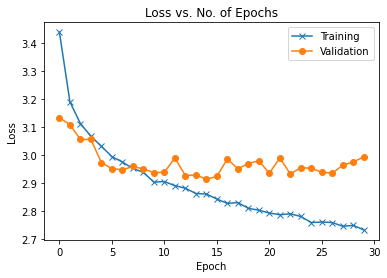

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, "-x")
plt.plot(val_losses, "-o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Loss vs. No. of Epochs")

Text(0.5, 1.0, 'Perplexity vs. No. of Epochs')

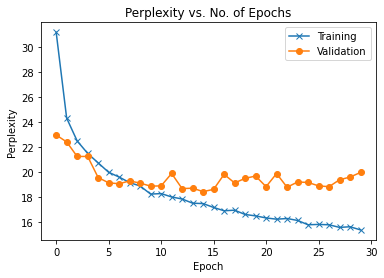

In [ ]:
plt.plot(train_perplexities, "-x")
plt.plot(val_perplexities, "-o")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend(["Training", "Validation"])
plt.title("Perplexity vs. No. of Epochs")

Text(0.5, 1.0, 'Accuracy vs. No. of Epochs')

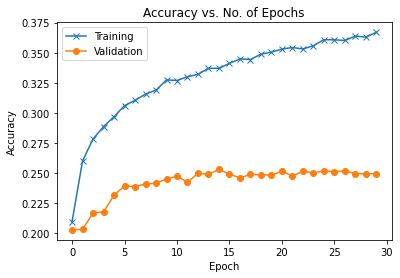

In [ ]:
plt.plot(train_accuracies, "-x")
plt.plot(val_accuracies, "-o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"])
plt.title("Accuracy vs. No. of Epochs")

Text(0.5, 1.0, 'AUC-ROC vs. No. of Epochs')

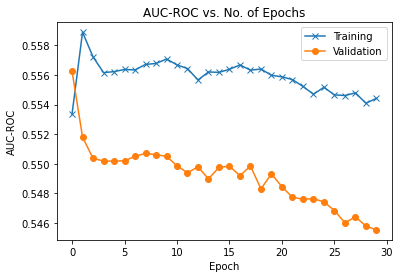

In [ ]:
plt.plot(train_auc, "-x")
plt.plot(val_auc, "-o")
plt.xlabel("Epoch")
plt.ylabel("AUC-ROC")
plt.legend(["Training", "Validation"])
plt.title("AUC-ROC vs. No. of Epochs")

Text(0.5, 1.0, 'F1 Score vs. No. of Epochs')

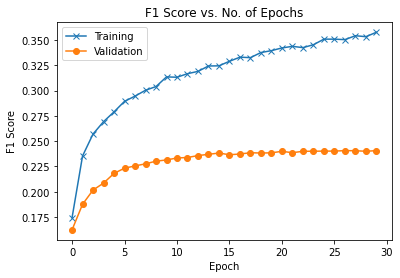

In [ ]:
plt.plot(train_f1, "-x")
plt.plot(val_f1, "-o")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend(["Training", "Validation"])
plt.title("F1 Score vs. No. of Epochs")

In [ ]:
model_encoder = EncoderModel(len(mapping_word_to_vector), embedding_dimensions, hidden_dimensions)
model_decoder = AttentionDecoderModel(len(mapping_word_to_vector), embedding_dimensions, hidden_dimensions)
model_encoder = model_encoder.cuda()
model_decoder = model_decoder.cuda()
model = Seq2SeqModel(model_encoder, model_decoder)

state = torch.load('best_model.tar')
model.load_state_dict(state['state_dict'])
model.cuda()

Seq2SeqModel(
  (model_encoder): EncoderModel(
    (embedded): Embedding(191, 250)
    (lstm): LSTM(250, 400, bidirectional=True)
    (linear): Linear(in_features=800, out_features=400, bias=True)
    (linear2): Linear(in_features=800, out_features=400, bias=True)
    (dropout): Dropout(p=0.23, inplace=False)
    (dropout2): Dropout(p=0.23, inplace=False)
  )
  (model_decoder): AttentionDecoderModel(
    (embedded): Embedding(191, 250)
    (lstm): LSTM(1050, 400)
    (linear): Linear(in_features=1200, out_features=1, bias=True)
    (non_linear_activation_function): Tanh()
    (fully_connected): Linear(in_features=400, out_features=191, bias=True)
    (softmax): Softmax(dim=0)
    (dropout): Dropout(p=0.23, inplace=False)
    (dropout2): Dropout(p=0.23, inplace=False)
  )
)

We can evaluate the best model on the test set.

In [ ]:
def test(model, test_batches_X, test_batches_Y, criterion, batch_size):
    N_test = 0
    test_loss = 0
    correct_test = 0
    area_under_curve = torch.zeros(len(test_batches_X), sequence_decoder * batch_size, len(mapping_word_to_vector) - 1)
    truths = torch.zeros(len(test_batches_X), sequence_decoder * batch_size)
    for index in range(len(test_batches_X)):
          model.eval()
          with torch.no_grad():
              encoder_inputs = test_batches_X[index]

              # encoder_input - [batch_size ,seq length]

              encoder_inputs = torch.LongTensor(encoder_inputs).cuda()
              encoder_inputs = torch.transpose(encoder_inputs, 0, 1)

              # encoder_input - [seq_length, batch_size]

              decoder_inputs = test_batches_Y[index]
              decoder_inputs = torch.LongTensor(decoder_inputs).cuda()
              decoder_inputs = torch.transpose(decoder_inputs, 0, 1)

              N_test += batch_size * sequence_decoder

              all_predictions = model(encoder_inputs, decoder_inputs, 0)

              truth = decoder_inputs[1:]
              
              all_predictions = all_predictions.reshape(all_predictions.size(0) * all_predictions.size(1), all_predictions.size(2))
              truth = truth.reshape(truth.size(0) * truth.size(1))

              loss = criterion(all_predictions, truth)

              correct_test += (all_predictions.argmax(1) == truth).sum().item()

              area = all_predictions
              area = area[:, :area.size(1) - 1]
              area = F.softmax(area, dim=1)
      
              area_under_curve[index] = area.cpu()
              truths[index] = truth.cpu()
        
              test_loss += loss.item()
      
    test_perplexity = math.exp(test_loss / len(test_batches_X))
    test_accuracy = correct_test / N_test

    area_under_curve =  area_under_curve.reshape(-1, area_under_curve.size(2)).detach().numpy()
    truths = truths.reshape(-1)
    auc_test = roc_auc_score(truths, area_under_curve, multi_class = 'ovr', average='weighted')
    f1_test = f1_score(truths, area_under_curve.argmax(1), average='weighted')

    print('Test Accuracy: {:.3f}, Test Perplexity: {:.3f}, Test AUC-ROC: {:.3f}, Test F1-Score: {:.3f}'.format(test_accuracy, test_perplexity, auc_test, f1_test))



In [ ]:
test(model, test_batches_X, test_batches_Y, criterion, batch_size)

Test Accuracy: 0.239, Test Perplexity: 19.630, Test AUC-ROC: 0.552, Test F1-Score: 0.224
